In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.applications import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [2]:
#configuring gpu memory usage

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set a memory limit for the first GPU (assuming at least one GPU is available)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Limit to 4GB
        
        # After setting the configuration, list logical GPUs to verify the configuration
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        # Print information about the available GPUs and logical GPUs
        print(len(gpus), "Physical GPU(s) available,", len(logical_gpus), "Logical GPU(s) configured.")
        
    except RuntimeError as e:
        # Print any runtime error that occurs during configuration
        print("Error:", e)
else:
    print("No GPU(s) available. TensorFlow cannot use GPU acceleration.")


1 Physical GPU(s) available, 1 Logical GPU(s) configured.


In [3]:
df = pd.read_csv("../balanced_data.csv")
df['cancer'] = df['cancer'].astype(str)
train_df, val_df = train_test_split(df, test_size=0.08, random_state=101)

In [5]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
INPUT_FOLDER = '../Dataset'

In [6]:
#setting up the training and validation datagenerator objects.

train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True       
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_FOLDER,                 
    x_col='image_name',                      
    y_col='cancer',                       
    target_size=IMAGE_SIZE,                
    batch_size=16,
    class_mode='binary'                   
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=INPUT_FOLDER,
    x_col='image_name',
    y_col='cancer',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 2130 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.


In [8]:
model_a = Sequential()

# Convolutional layers
model_a.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512,512,3)))
model_a.add(MaxPooling2D((2, 2)))

model_a.add(Conv2D(64, (3, 3), activation='relu'))
model_a.add(MaxPooling2D((2, 2)))

model_a.add(Conv2D(128, (3, 3), activation='relu'))
model_a.add(MaxPooling2D((2, 2)))

model_a.add(Conv2D(256, (3, 3), activation='relu'))
model_a.add(MaxPooling2D((2, 2)))


model_a.add(Flatten())

model_a.add(Dense(256, activation='relu'))
model_a.add(Dropout(0.2)) 

model_a.add(Dense(1,activation='sigmoid'))

optimizer = Adam(learning_rate=0.01)
model_a.compile(optimizer='adam',loss=['binary_crossentropy'],metrics=['accuracy'])

In [9]:
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [10]:
train_generator.samples

2130

In [11]:
history_a = model_a.fit(train_generator,steps_per_epoch=50,epochs=50,validation_data=val_generator)

Epoch 1/50
50/50 [==============================] - 72s 1s/step - loss: 0.7441 - accuracy: 0.5125 - val_loss: 0.6947 - val_accuracy: 0.4946
Epoch 2/50
50/50 [==============================] - 32s 633ms/step - loss: 0.6942 - accuracy: 0.4825 - val_loss: 0.6932 - val_accuracy: 0.4516
Epoch 3/50
50/50 [==============================] - 24s 470ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6935 - val_accuracy: 0.4946
Epoch 4/50
50/50 [==============================] - 29s 589ms/step - loss: 0.6936 - accuracy: 0.4888 - val_loss: 0.6960 - val_accuracy: 0.5215
Epoch 5/50
50/50 [==============================] - 59s 1s/step - loss: 0.6943 - accuracy: 0.4938 - val_loss: 0.6938 - val_accuracy: 0.5108
Epoch 6/50
50/50 [==============================] - 60s 1s/step - loss: 0.6939 - accuracy: 0.5216 - val_loss: 0.6938 - val_accuracy: 0.4462
Epoch 7/50
50/50 [==============================] - 53s 1s/step - loss: 0.6935 - accuracy: 0.4898 - val_loss: 0.6933 - val_accuracy: 0.4624
Epoch 8/50


In [12]:
# Plot training history
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

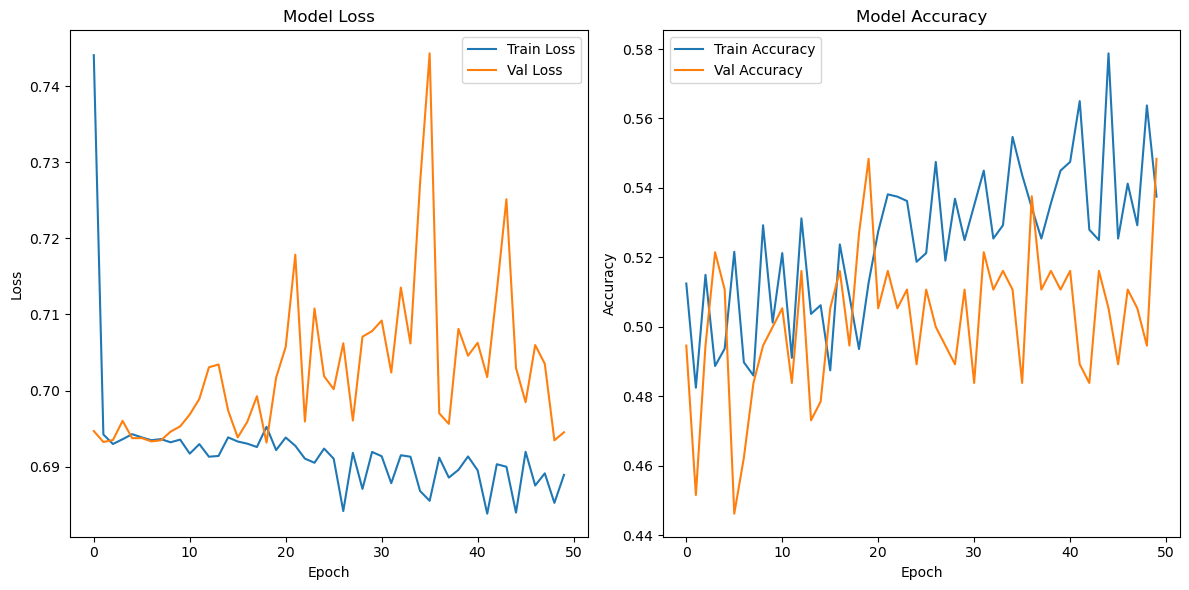

In [13]:
plot_training_history(history_a)

In [14]:
preds_a = model_a.predict(val_generator)

12/12 [==============================] - 1s 98ms/step


In [15]:
preds_a

array([[0.43460247],
       [0.4850777 ],
       [0.5003949 ],
       [0.48556757],
       [0.5177558 ],
       [0.48512474],
       [0.515284  ],
       [0.44667622],
       [0.5114971 ],
       [0.4530584 ],
       [0.4675749 ],
       [0.5275586 ],
       [0.45847535],
       [0.52324504],
       [0.5826635 ],
       [0.5254548 ],
       [0.48688412],
       [0.4526891 ],
       [0.46845904],
       [0.45423034],
       [0.4526891 ],
       [0.5242362 ],
       [0.5343506 ],
       [0.5846382 ],
       [0.5644265 ],
       [0.51540184],
       [0.5167209 ],
       [0.45165157],
       [0.46773377],
       [0.45382762],
       [0.4795585 ],
       [0.51026255],
       [0.45977157],
       [0.5574024 ],
       [0.53473467],
       [0.497074  ],
       [0.5365352 ],
       [0.54771334],
       [0.5124712 ],
       [0.484625  ],
       [0.45731133],
       [0.5105225 ],
       [0.4537057 ],
       [0.46247458],
       [0.477094  ],
       [0.48368913],
       [0.50167805],
       [0.472

In [16]:
preds_a = (model_a.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes


12/12 [==============================] - 1s 79ms/step


In [17]:
val_loss_a, val_accuracy_a = model_a.evaluate(val_generator, steps=len(val_generator))

12/12 [==============================] - 1s 60ms/step - loss: 0.6945 - accuracy: 0.5484


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

In [19]:
conf_matrix = confusion_matrix(y_true, preds_a)
class_names = val_generator.class_indices.keys()
report = classification_report(y_true, preds_a, target_names=class_names)

In [20]:
print(conf_matrix)

[[52 42]
 [44 48]]


In [22]:
print(report)

              precision    recall  f1-score   support

           0       0.54      0.55      0.55        94
           1       0.53      0.52      0.53        92

    accuracy                           0.54       186
   macro avg       0.54      0.54      0.54       186
weighted avg       0.54      0.54      0.54       186

